In this colab, you'll work with word embeddings and train a basic neural network to predict text sentiment. At the end, you'll be able to visualize how the network sees the related sentiment of each word in the dataset.


Embeddings are clusters of vectors in multi-dimensional space, where each vector represents a given word in those dimensions. While it’s difficult for us humans to think in many dimensions, luckily the TensorFlow Projector makes it fairly easy for us to view these clusters in a 3D projection (later Colabs will generate the necessary files for use with the projection tool).

This can be very useful for sentiment analysis models, where you’d expect to see clusters around either more positive or more negative sentiment associated with each word.
An example embedding projection, post-training. Negative sentiment words are separated quite distinctly from positive sentiment words, such as “incredible”.

An example of a post-training embedding projection, with clear distinctions between positive and negative sentiments.

https://video.udacity-data.com/topher/2020/March/5e6fb5c8_sphereized-viz/sphereized-viz.png


To create our embeddings, we’ll first use an embeddings layer, called tf.keras.layers.Embedding. This takes three arguments: 
* the size of the tokenized vocabulary, 
* the number of embedding dimensions to use, 
* as well as the input length (from when you standardized sequence length with padding and truncation).

The output of this layer needs to be reshaped to work with any fully-connected layers. 
You can do this with 
* a pure Flatten layer, 
* or use GlobalAveragePooling1D for a little additional computation that sometimes creates better results.

In our case, we’re only looking at positive vs. negative sentiment, so only a single output node is needed (0 for negative, 1 for positive). You’ll be able to use a binary cross entropy loss function since the result is only binary classification.


In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

We're going to use a dataset containing Amazon and Yelp reviews, with their related sentiment (1 for positive, 0 for negative). This dataset was originally extracted from [here](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set).

In [1]:
!wget --no-check-certificate \
    -O /tmp/sentiment.csv https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P

/tmp/sentiment.csv: No such file or directory
SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = C:\Program Files (x86)\GnuWin32/etc/wgetrc


In [2]:
path = tf.keras.utils.get_file('sentiment.csv', 
                               'https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P')
print (path)

C:\Users\Amir\.keras\datasets\sentiment.csv


In [3]:
import numpy as np
import pandas as pd

dataset = pd.read_csv(path)

sentences = dataset['text'].tolist()              # This is X
labels = dataset['sentiment'].tolist()            # This is Y

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)         # 80% for training

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]     # 20% for testing
training_labels = labels[0:training_size] 
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)  # pandas ds to numpy array
testing_labels_final = np.array(testing_labels)

In [4]:
# Tokenize the dataset, including padding and OOV

vocab_size = 1000                 # max size for tokenizing words
embedding_dim = 16                # not sure why dim are 16 here
max_length = 100                  # length of the sentence
trunc_type='post'                 # truncate the sentence at the end
padding_type='post'               # padd with 0s are the end not the beginning of the sentence
oov_tok = "<OOV>"                 # out of vocabulary tag


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)                       # get the token bhai for nihari :)
word_index = tokenizer.word_index                                # token index as list
sequences = tokenizer.texts_to_sequences(training_sentences)     # words to number here
padded = pad_sequences(sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)  # word to number for testing sentence note those are not used for tokenization
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

In [5]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

good case excellent value ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
Good case Excellent value.


In [6]:
# Build a basic sentiment network
# Note the embedding layer is first, 
# and the output is only 1 node as it is either 0 or 1 (negative or positive)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),   # vocab_size = 1000, embedding_dim = 16
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           16000     
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 9606      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 25,613
Trainable params: 25,613
Non-trainable params: 0
_________________________________________________________________


In [7]:
num_epochs = 10
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 1593 samples, validate on 399 samples
Epoch 1/10
1593/1593 [==============================] - 2s 951us/sample - loss: 0.6927 - accuracy: 0.5166 - val_loss: 0.7004 - val_accuracy: 0.4110
Epoch 2/10
1593/1593 [==============================] - 0s 139us/sample - loss: 0.6903 - accuracy: 0.5223 - val_loss: 0.7059 - val_accuracy: 0.4110
Epoch 3/10
1593/1593 [==============================] - 0s 139us/sample - loss: 0.6818 - accuracy: 0.5223 - val_loss: 0.6962 - val_accuracy: 0.4110
Epoch 4/10
1593/1593 [==============================] - 0s 172us/sample - loss: 0.6602 - accuracy: 0.5273 - val_loss: 0.6973 - val_accuracy: 0.4211
Epoch 5/10
1593/1593 [==============================] - 0s 136us/sample - loss: 0.6221 - accuracy: 0.6353 - val_loss: 0.6692 - val_accuracy: 0.5138
Epoch 6/10
1593/1593 [==============================] - 0s 159us/sample - loss: 0.5694 - accuracy: 0.7219 - val_loss: 0.6454 - val_accuracy: 0.6090
Epoch 7/10
1593/1593 [==============================] - 0s 164us/

In [18]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [20]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

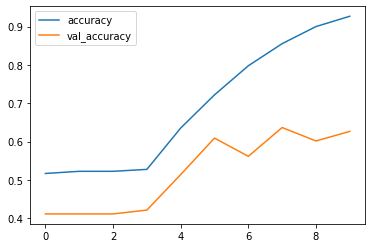

In [22]:
losses[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

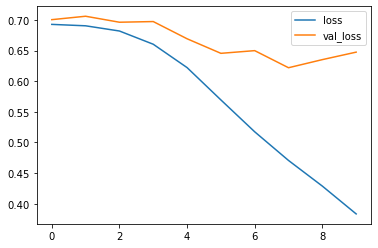

In [23]:
losses[['loss','val_loss']].plot()

In [8]:
# Head to http://projector.tensorflow.org/ and load these files, then click the "Sphereize" checkbox.
#  
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(1000, 16)


In [9]:
import io

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [10]:
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [16]:
# Predicting Sentiment in New Reviews Use the model to predict a review   
fake_reviews = ['I love this phone', 'I hate spaghetti', 
                'Everything was cold',
                'Everything was hot exactly as I wanted', 
                'Everything was green', 
                'the host seated us immediately',
                'they gave us free chocolate cake', 
                'not sure about the wilted flowers on the table',
                'only works when I stand on tippy toes',
                'bats are all wearing underwears with tie',
                'bat was runnig the show',
                'does not work when I stand on my head']

print(fake_reviews) 

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(fake_reviews)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           

print('\nHOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!\n')              

classes = model.predict(fakes_padded)

# The closer the class is to 1, the more positive the review is deemed to be
for x in range(len(fake_reviews)):
  print(fake_reviews[x])
  print(classes[x])
  print('\n')

# Try adding reviews of your own
# Add some negative words (such as "not") to the good reviews and see what happens
# For example:
# they gave us free chocolate cake and did not charge us

['I love this phone', 'I hate spaghetti', 'Everything was cold', 'Everything was hot exactly as I wanted', 'Everything was green', 'the host seated us immediately', 'they gave us free chocolate cake', 'not sure about the wilted flowers on the table', 'only works when I stand on tippy toes', 'bats are all wearing underwears with tie', 'bat was runnig the show', 'does not work when I stand on my head']

HOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!

I love this phone
[0.9672076]


I hate spaghetti
[0.42844096]


Everything was cold
[0.6813464]


Everything was hot exactly as I wanted
[0.7650672]


Everything was green
[0.6967425]


the host seated us immediately
[0.7959647]


they gave us free chocolate cake
[0.7898]


not sure about the wilted flowers on the table
[0.42844096]


only works when I stand on tippy toes
[0.9191233]


bats are all wearing underwears with tie
[0.83884823]


bat was runnig the show
[0.49457568]


does not work when I stand on my he